# Determination of a Deformation Rate Spectrum for Arbitrary Grainsize Distributions

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, brentq, nnls, lsq_linear, minimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
from scipy.special import gamma, erf

## Helper Functions

### `xlogspace`

This does the same as `numpy.logspace()`, but takes real start and end values instead of
powers of a chosen base. In any case, the result is independent of the chosen base:

$$
x_n = x_\text{start}\,{\Bigl(\frac{x_\text{end}}{x_\text{start}}\Bigr)} ^ {\frac{n}{N - 1}}
\quad,\quad
n = 0, 1, \dots, N-1
$$

In [2]:
def xlogspace(start: float, end: float, num: int = 50):
    """Numbers spaced evenly on a log scale.

    Parameters
    ----------
    start : float
        Start value of the sequence.
    end : float
        End value of the sequence.
    num : int
        Number of samples to generate.
    """
    if num < 2:
        raise ValueError(
            'This function is meant to generate a range of several values, '\
            f'not {num=}.')
    return start * (end / start) ** (np.arange(num) / (num - 1))

In [3]:
def moving_avg(x, width: int = 3):
    """Computes a moving average of input `x` and window of `width` samples.

    The window is centered around the running index. To make this precise,
    `width` is increased by 1 if an even value is given. At the start and end of
    `x` the window width is decreased, so that the first and last elements
    returned always match the first and last elements of input `x`.

    Parameters
    ----------
    x : ArrayLike
        Input values to average.
    width: int
        Window width.
    """
    x = np.asarray(x)
    if width % 2 == 0:
        width += 1
    lnh = (width - 1) // 2
    ret = np.empty_like(x)
    idx = (
        np.arange(lnh, x.shape[0] - lnh)[:, None] * np.ones(width, dtype=int)
    ) + np.arange(width) - lnh
    ret[lnh:-lnh] = np.sum(x[idx], axis=1)
    ret[lnh:-lnh] /= width
    ret[:lnh] = np.cumsum(x[:2 * lnh])[::2] / (2 * np.arange(lnh) + 1)
    ret[-lnh:] = np.cumsum(x[-2 * lnh:][::-1])[::-2] \
        / ((2 * np.arange(lnh) + 1)[::-1])
    ret[-1] = x[-1]  # Don't understand why above does not work for last element
    return ret

## Distributions

### Weibull/Rosin-Rammler

$$
m(x) = m_0\,\bigl(1 - e^{-(x/\lambda)^q}\bigr)
$$

$$
\mu(x) = \frac{dm}{dx}
= m_0 \frac{q}{\lambda}\, \Bigl(\frac{x}{\lambda}\Bigr)^{q-1}\, e^{-(x/\lambda)^q}
$$

In [4]:
def weibull(x, lmda, q):
    y = x / lmda
    return (q / lmda) * y ** (q - 1) * np.exp(-(y ** q))


def weibull_cumul(x, lmda, q):
    return 1. - np.exp(-((x / lmda) ** q))

## Grain Size Data

In [5]:
data = np.loadtxt('../data/grainsizes/JGR2006_grainsizes.txt',
                  skiprows=2, delimiter=',')

In [6]:
data

array([[6.25000000e-02, 1.10400000e+00, 1.80700000e+00],
       [8.83883500e-02, 2.91000000e+00, 4.51000000e+00],
       [1.25000000e-01, 4.81500000e+00, 7.22300000e+00],
       [1.76776700e-01, 9.51200000e+00, 1.29900000e+01],
       [2.50000000e-01, 1.58700000e+01, 1.96900000e+01],
       [3.53553390e-01, 2.36900000e+01, 2.76400000e+01],
       [5.00000000e-01, 3.39900000e+01, 3.97700000e+01],
       [7.07106780e-01, 4.74900000e+01, 5.13400000e+01],
       [1.00000000e+00, 6.25800000e+01, 6.25800000e+01],
       [1.41421356e+00, 7.98000000e+01, 7.95700000e+01],
       [2.00000000e+00, 1.00000000e+02, 1.00000000e+02]])

In [7]:
x, ams, ast = 1e-3 * data[:, 0], data[:, 1], data[:, 2]

In [8]:
fig, ax = plt.subplots()

ax.plot(x, ast, marker='s', mfc='none', label=r'AST')
ax.plot(x, ams, marker='x', label='AMS')
ax.set(
    xscale='log', yscale='log',
    xlabel=r'grain size / m', ylabel=r'mass \%'
)
ax.legend(loc='lower right')
fig.set_size_inches(6, 4)

In [9]:
diff_m_ams = (ams[1:] - ams[:-1]) / 100
diff_m_ams

array([0.01806, 0.01905, 0.04697, 0.06358, 0.0782 , 0.103  , 0.135  ,
       0.1509 , 0.1722 , 0.202  ])

In [10]:
mu_ams = diff_m_ams / (x[1:] - x[:-1])
mu_ams

array([697.61108761, 520.32618033, 907.16480579, 868.30284896,
       755.16600664, 703.327991  , 651.83766558, 515.20482447,
       415.72757782, 344.8355684 ])

In [11]:
diff_m_ast = (ast[1:] - ast[:-1]) / 100
mu_ast = diff_m_ast / (x[1:] - x[:-1])
mu_ast

array([1044.09898661,  741.02095918, 1113.82146796,  915.00929349,
        767.71991723,  828.28820688,  558.64902153,  383.75760286,
        410.1748866 ,  348.76191398])

In [12]:
res_ast = curve_fit(weibull, x[:-1], mu_ast, p0=[5e-4, 1.2])
res_ast

(array([9.42156495e-04, 1.00251387e+00]),
 array([[ 8.43731156e-09, -5.38385151e-06],
        [-5.38385151e-06,  6.90908291e-03]]))

In [13]:
res_ams = curve_fit(weibull, x[:-1], mu_ams, p0=[5e-4, 1.2])
res_ams

(array([9.96432453e-04, 1.17998155e+00]),
 array([[ 5.94203676e-09, -4.07043027e-06],
        [-4.07043027e-06,  5.49947019e-03]]))

In [14]:
res_4 = curve_fit(
    lambda x, lmda: weibull(x, lmda, 4), x[:-1], mu_ams, p0=[5e-4,])
res_4

(array([0.00120775]), array([[3.46768461e-08]]))

In [15]:
lmda0 = 1.25e-4 / .75 ** .25
lmda0

0.00013432124147794275

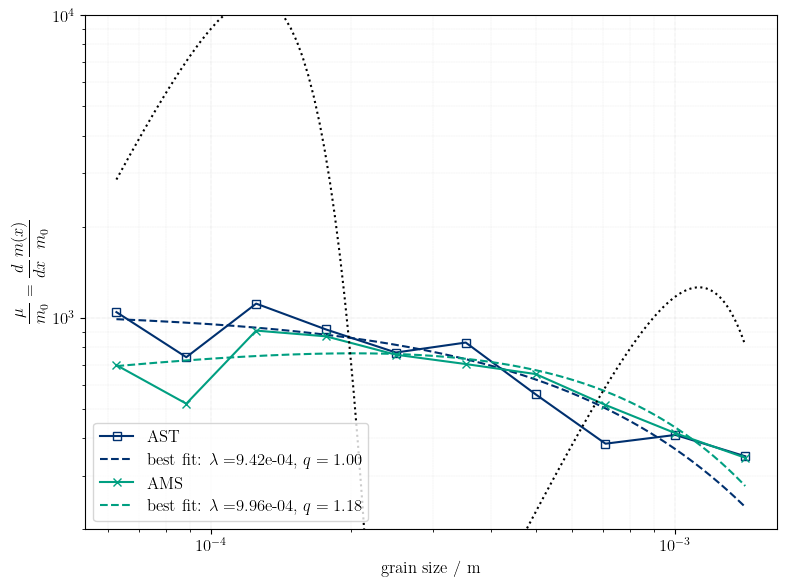

In [16]:
fig, ax = plt.subplots()

xp = np.linspace(x[0], x[-2], 300)

l, = ax.plot(x[:-1], mu_ast, marker='s', mfc='none', label='AST')
ax.plot(
    xp, weibull(xp, *res_ast[0]), ls='dashed', color=l.get_color(),
    label=fr'best fit: $\lambda=${res_ast[0][0]:.2e}, $q={res_ast[0][1]:.2f}$'
)
l, = ax.plot(x[:-1], mu_ams, marker='x', label='AMS')
ax.plot(
    xp, weibull(xp, *res_ams[0]), ls='dashed', color=l.get_color(),
    label=fr'best fit: $\lambda=${res_ams[0][0]:.2e}, $q={res_ams[0][1]:.2f}$'
)
ax.plot(xp, weibull(xp, res_4[0][0], 4), ls='dotted', color='k')
ax.plot(xp, weibull(xp, lmda0, 4), ls='dotted', color='k')
ax.set(
    xscale='log', yscale='log', ylim=(2e2, 1e4), #aspect=1,
    xlabel=r'grain size / m',
    ylabel=r'$\dfrac{\mu}{m_0}=\dfrac{d}{dx}\dfrac{m(x)}{m_0}$',
)
ax.grid(which='major', axis='both', ls='dotted', lw=.33)
ax.grid(which='minor', axis='both', ls='dotted', lw=.17)
ax.legend(loc='lower left')
fig.set_size_inches(8, 6.)
fig.tight_layout(pad=1)

## Base Mode Expansion

Expand grain size distribution into base modes specified by length parameter $\lambda$

$$
\mu(x) = \sum_{l}a(\lambda_l)\,\mu_l(x)
\quad,\quad
\lambda_l = \frac{\lambda_0}{2^{l/2}}
\quad,\quad
l = 0, 1, 2, \dots, L
$$

Conservation of mass:

$$
m_0 = \int_0^\infty \mu(x)\,dx
= \sum_{l} a_l \int_0^\infty\!\! \mu_l(x)\,dx
= \sum_{l} a_l m_{0,l}
$$

### Norming condition for the $\mu_l$

Assume that the integral over $\sigma$ is constant, i.e. independent of $l$.
This constant could be $1$, but this would mess with units, so we *choose* $S_0$

$$
\int_0^\infty \sigma_l(x)\,dx
= \int_0^\infty \frac{f_{\!S}}{\rho f_{\!V}} \frac{\mu_l(x)}{x}\,dx = S_0
$$

Then the total surface area is

$$
S_0 = \int_0^\infty \sigma(x)\,dx = \frac{f_{\!S}}{\rho f_{\!V}} \int_0^\infty \frac{\mu(x)}{x}\,dx
= \frac{f_{\!S}}{\rho f_{\!V}} \sum_{l=1}^L a_l \int_0^\infty \frac{\mu_l(x)}{x}\,dx
= \,S_0\sum_{l=1}^L a_l
\quad,
$$

and

$$
\sum_{l-1}^L a_l = 1
\quad.
$$

At same amplitude $a_l$ the 'modes' $\mu_l$ are associated with the same amount
of brittle surface area.

### Weibull based $\mu_l$

$$
m_l(x) = \int_0^x \mu_l(x)\,dx
= m_{0,l}\,(1 - e^{-(x/\lambda_l)^q})
$$

$$
\mu_l(x) = m_{0,l}\,\frac{q}{\lambda_l}\, \Bigl(\frac{x}{\lambda_l}\Bigr)^{q-1}\, e^{-(x/\lambda_l)^q}
$$

- $m_{0,l}$: mass associated with mode $l$.  
- $S_{0,l}$: Surface area of mode $l$. By definition, $S_{0,l} = S_0$.

$$
S_{0,l} = \frac{f_{\!S}}{\rho f_{\!V}} \int_0^\infty\!\frac{\mu_l}{x}\,dx
= \frac{m_{0,l} f_{\!S}}{\rho f_{\!V}} \int_0^\infty\!\frac{q}{\lambda_l^q}\,x^{q-2} e^{-{(x/\lambda_l)}^q}\,dx
= \frac{m_{0,l} f_{\!S}}{\rho f_{\!V}} \frac{\Gamma(1 - 1/q)}{\lambda_l}
=S_0
$$



$$
m_{0,l} = \frac{\rho f_{\!V}}{f_{\!S}} \frac{S_0\lambda_l}{\Gamma(1 - 1/q)}
$$

In [17]:
def m0l(lmda, q=4., sfa=1., rho=2.8e3):
    return rho * lmda * sfa / gamma(1 - 1 / q)

In [18]:
def weibull_mul(x, lmda, q, sfa=1.):
    return m0l(lmda, q, sfa) * weibull(x, lmda, q)

## Interpolate Grain Sizes

In [19]:
ast

array([  1.807,   4.51 ,   7.223,  12.99 ,  19.69 ,  27.64 ,  39.77 ,
        51.34 ,  62.58 ,  79.57 , 100.   ])

In [20]:
spl_ast = UnivariateSpline(np.log(x[:]), np.log(ast / 100), k=2, s=0, ext=3)


In [21]:
# spl_ast = UnivariateSpline(np.log(x[:-1]), np.log(mu_ast), k=3, s=.025, ext=3)
# spl_ast = UnivariateSpline(np.log(x[:-1]), np.log(mu_ast), k=1, s=0, ext=3)
spl_ams = UnivariateSpline(np.log(x[:-1]), np.log(mu_ams), k=1, s=0, ext=3)

def spl_ast_mu(x):
    return np.exp(spl_ast(np.log(x))) * spl_ast.derivative(n=1)(np.log(x)) / x

def spl_ams_mu(x):
    return np.exp(spl_ams(np.log(x)))

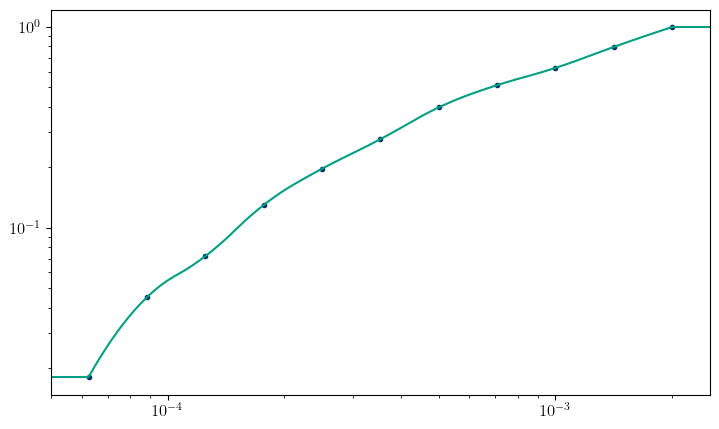

In [22]:
fig, ax = plt.subplots()

xp = xlogspace(1e-5, 1e-2, 600)

ax.plot(x, ast / 100, '.')
ax.plot(xp, np.exp(spl_ast(np.log(xp))))
ax.set(
    xscale='log', yscale='log',
    xlim=(5e-5, 2.5e-3)
);

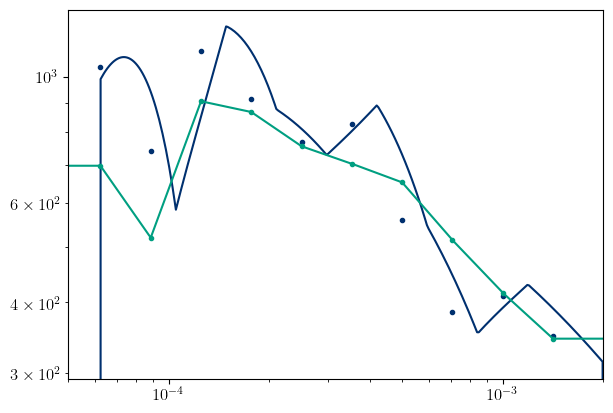

In [23]:
fig, ax = plt.subplots()
xp = np.logspace(-5, -2, 600)

l, = ax.plot(x[:-1], mu_ast, '.')
ax.plot(xp, spl_ast_mu(xp), color=l.get_color())
l, = ax.plot(x[:-1], mu_ams, '.')
ax.plot(xp, spl_ams_mu(xp), color=l.get_color())
ax.set(
    xscale='log', yscale='log',
    xlim=(5e-5, 2e-3)
)
fig.set_size_inches(6, 4)
fig.tight_layout(pad=.2)

In [24]:
ast / 100

array([0.01807, 0.0451 , 0.07223, 0.1299 , 0.1969 , 0.2764 , 0.3977 ,
       0.5134 , 0.6258 , 0.7957 , 1.     ])

In [25]:
x

array([6.25000000e-05, 8.83883500e-05, 1.25000000e-04, 1.76776700e-04,
       2.50000000e-04, 3.53553390e-04, 5.00000000e-04, 7.07106780e-04,
       1.00000000e-03, 1.41421356e-03, 2.00000000e-03])

In [26]:
xintgr = xlogspace(x[0], x[-1], 300)

In [27]:
rho0 = 2.8e3

In [28]:
S0 = np.trapz(spl_ast_mu(xintgr) / (rho0 * xintgr), xintgr)
S0

0.8826458082203927

## Approximate the measured, interpolated $\mu(x)$

Choose some arbitrary number, $M$ defining a range of discrete sizes, $x_m$, evenly
spaced on a log scale, at which $\mu$ is evaluated. The $x_m$ start at the start of
the grain size distribution $x_\text{min}$, and end at its end $x_\text{max}$.

$$
x_m = x_\text{min}\, {\Bigl(\frac{x_\text{max}}{x_\text{min}}\Bigr)}^{\frac{m}{M-1}}
$$

### `mu_approx()`

Model used to fit amplitudes $a_l$ to the measured grain size distribution.  
`mu_approx(x, a, lmdas, q, sfa)`:
- `a`: $a_l$
- `lmdas`: $\lambda_l$
- `q`: $q$
- `sfa`: $S_0$

$$
\mu_\text{approx}(x) = \sum_{l=0}^{L-1} a_l \mu_l(x)
$$

In [29]:
def mu_approx(x, a, lmdas, q, sfa=1.):
    ret = np.zeros_like(x)
    for lmda, aa in zip(lmdas, a):
        ret += aa * weibull_mul(x, lmda, q, sfa)
    return ret

### `mx_approx()`

In [30]:
def mx_approx(x, a, lmdas, q, sfa=1.):
    ret = np.zeros_like(x)
    for lmda, aa in zip(lmdas, a):
        ret += aa * m0l(lmda, q, sfa) * weibull_cumul(x, lmda, q)
    return ret

### `ltrend()`

In [31]:
def ltrend(lmda, a, b):
    return a * (np.log(lmda) - b)

### Set Up Linear System

$$
\mu_k = \mu(x_k) = 
\sum_{l=0}^{L-1} a_l\, \mu_l(x_k) = \sum_{l=0}^{L-1} a_l\, \mu_{k,l}
$$

Can be written as linear equation of a vector $\boldsymbol{\mu}$, a $K_\text{max}\times L$
matrix $M$ and an amplitudes vector $\boldsymbol a$

$$
\boldsymbol{\mu} = M \cdot \boldsymbol{a}
$$

Additional condition(s) for the conservation of mass can be added to
$\boldsymbol{\mu}$ and $M$

$$
\begin{align}
% \boldsymbol{\mu} &= M\cdot\boldsymbol{a} \\
\begin{pmatrix}\mu_0 \\ \mu_1 \\ \dots \\ \mu_{K-1} \\ 1 \end{pmatrix}
&=
\begin{pmatrix}
\mu_{0,0} & \mu_{0,1} & \dots & \mu_{0,L-1} \\
\mu_{1, 0} & \ddots \\
\vdots \\
\mu_{K-1, 0} \\
m_{0, 0} & m_{0, 1} & \dots & m_{0, L-1}
\end{pmatrix}
\cdot
\begin{pmatrix} a_0 \\ a_1 \\ \vdots \\ a_{L-1} \end{pmatrix} \\
\boldsymbol{v} &= B\cdot\boldsymbol{a}
\end{align}
$$

In [32]:
q = 4
Kmax = 600
Lmax = 20

In [33]:
lambdas = xlogspace(x[0], x[-1], Lmax)
lambdas

array([6.25000000e-05, 7.50064200e-05, 9.00154086e-05, 1.08027737e-04,
       1.29644381e-04, 1.55586574e-04, 1.86719870e-04, 2.24083024e-04,
       2.68922647e-04, 3.22734799e-04, 3.87314911e-04, 4.64817678e-04,
       5.57828959e-04, 6.69452051e-04, 8.03411227e-04, 9.64175998e-04,
       1.15711024e-03, 1.38865114e-03, 1.66652401e-03, 2.00000000e-03])

In [34]:
xk = xlogspace(x[0], x[-2], Kmax)

In [35]:
weight_mass = 2e2
weight_surf = 4e2
a = np.ones(Lmax) / Lmax

In [36]:
np.trapz(spl_ast_mu(xk), xk)

0.7776304469743449

In [37]:
def obj_func(a):
    muk = spl_ast_mu(xk)
    ret = np.sum((
        muk - np.sum(
            np.asarray([aa * weibull_mul(xk, lm, q, S0)
                        for aa, lm in zip(a, lambdas)]), axis=0
        )) ** 2 / muk)
    ret += (
        weight_mass * (0.9333797794658529 - np.sum(a * m0l(lambdas, q, S0)))
    ) ** 2 / 0.9333797794658529
    ret += (weight_surf * (1. - a.sum())) ** 2
    return ret

In [38]:
def bounds(amp):
    ret = 0.2 * np.asarray(Lmax * [[-1., 1.]]) / Lmax + amp[:, None]
    ret[ret < 0.] = 0.
    return ret

In [39]:
a = np.ones(Lmax) / Lmax
for i in range(30):
    bnds = bounds(a)
    res = minimize(obj_func, a, bounds=bnds)
    print(i, f"bounds l,u: {bnds[:, 0].mean():.5f}, {bnds[:, 1].mean():.5f}",
          f"obj_func: {res['fun']}")
    a = res['x'].copy()
    dff = np.abs(a[2:] - a[:-2])
    a = moving_avg(a, width=int(np.round(Lmax / 4)))

0 bounds l,u: 0.04000, 0.06000 obj_func: 19849.988707434364
1 bounds l,u: 0.04345, 0.06345 obj_func: 11644.941216808056
2 bounds l,u: 0.04430, 0.06430 obj_func: 10004.65418135765
3 bounds l,u: 0.04467, 0.06467 obj_func: 9631.619866978617
4 bounds l,u: 0.04512, 0.06512 obj_func: 9543.672992654607
5 bounds l,u: 0.04563, 0.06513 obj_func: 9669.142415892928
6 bounds l,u: 0.04532, 0.06482 obj_func: 9784.313781905923
7 bounds l,u: 0.04532, 0.06482 obj_func: 9793.168357076185
8 bounds l,u: 0.04532, 0.06482 obj_func: 9794.50594755224
9 bounds l,u: 0.04532, 0.06482 obj_func: 9795.106201481178
10 bounds l,u: 0.04532, 0.06482 obj_func: 9795.221409767639
11 bounds l,u: 0.04532, 0.06482 obj_func: 9795.241393221157
12 bounds l,u: 0.04532, 0.06482 obj_func: 9795.248090734502
13 bounds l,u: 0.04532, 0.06482 obj_func: 9795.24973358461
14 bounds l,u: 0.04532, 0.06482 obj_func: 9795.250195137332
15 bounds l,u: 0.04532, 0.06482 obj_func: 9795.250312820928
16 bounds l,u: 0.04532, 0.06482 obj_func: 9795.250

In [40]:
res['x']

array([0.08701472, 0.08812088, 0.05922705, 0.05690526, 0.05486735,
       0.07540577, 0.0779313 , 0.07430962, 0.05714247, 0.05528496,
       0.071044  , 0.06864376, 0.06287076, 0.03537531, 0.02641998,
       0.02185849, 0.03557536, 0.0400633 , 0.05281933, 0.        ])

In [41]:
res['x'] * Lmax

array([1.7402943 , 1.76241769, 1.18454106, 1.13810528, 1.09734694,
       1.50811542, 1.55862601, 1.48619231, 1.14284939, 1.10569923,
       1.42088004, 1.37287519, 1.25741527, 0.70750622, 0.52839963,
       0.43716976, 0.71150728, 0.80126591, 1.05638659, 0.        ])

In [42]:
bnds[-3:]

array([[0.0200633 , 0.0400633 ],
       [0.03281933, 0.05281933],
       [0.        , 0.01      ]])

In [43]:
res['x'].sum()

1.1008796755690617

In [44]:
np.sum(m0l(lambdas, q, S0) * res['x']) / 0.9333797794658529

0.9768386971750129

In [45]:
fig, ax = plt.subplots()

ax.plot(lambdas, res['x'] * Lmax, marker='.', lw=.5)
ax.set(
    xscale='log', yscale='linear',
    xlabel=r'$\lambda\ /\ \mathrm{m}$',
    ylabel=r'$a(\lambda)\,L_\text{max}$',
    ylim=(0, 2)
)
fig.set_size_inches(6, 5)
fig.tight_layout(pad=1)

#### Approx. Solution

In [46]:
xp1 = xlogspace(x[0] / 2, x[-1], 300)
xp2 = xlogspace(x[0], x[-2], 300)
fig, ax = plt.subplots()

ax.plot(x[:-1], mu_ast, '.', label='measured')
ax.plot(xp2, spl_ast_mu(xp2), label='interpolated')
ax.plot(xp1, mu_approx(xp1, res['x'], lambdas, q, S0),
        zorder=-1, label='approximated')
for aa, lmda in zip(res['x'], lambdas):
    ax.plot(xp1, aa * weibull_mul(xp1, lmda, q, S0) * Lmax / 10,
            lw=.25, color='k', zorder=-1)
ax.set(
    # aspect=1,
    xscale='log', yscale='log',
    xlabel=r'$x\ /\ \mathrm{m}$', ylabel='$\mu(x)\ /\ \mathrm{kg\,m^{-1}}$',
    ylim=(80, 1.5e3)
)
ax.legend(loc='upper right')
fig.set_size_inches(6, 4)
fig.tight_layout(pad=.2)

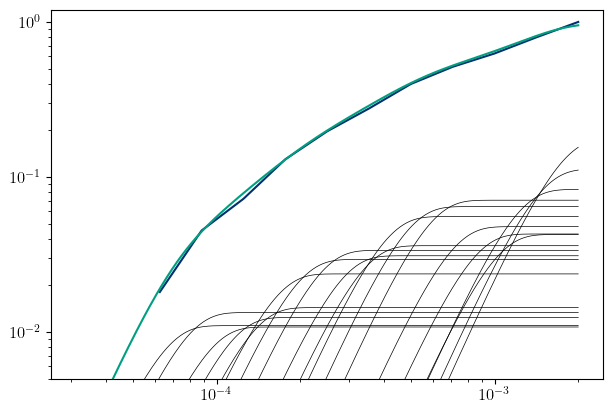

In [47]:
xp = xlogspace(x[0] / 2, x[-1], 300)
fig, ax = plt.subplots()

ax.plot(x, ast / 1e2)
ax.plot(xp, mx_approx(xp, res['x'], lambdas, q, S0) / 0.9333797794658529)
for aa, lmda in zip(res['x'], lambdas):
    ax.plot(xp, aa * m0l(lmda, q, S0) * weibull_cumul(xp, lmda, q), lw=.5, color='k')
ax.set(
    xscale='log', yscale='log',
    ylim=(5e-3, 1.2)
)
fig.set_size_inches(6, 4)
fig.tight_layout(pad=.2)

## Map $\lambda$ to Deformation Rate

$$
\lambda = {\biggl(\frac{\gamma}{\rho{\dot\varepsilon}^2}\biggr)}^{1/3}
$$

$\gamma$: Brittle energy per area

In [48]:
gamma_over_rho = 1e-2
epsdots = np.sqrt(gamma_over_rho / lambdas ** 3)
epsdots

array([202385.77025078, 153940.30550688, 117091.32331876,  89062.95171622,
        67743.78445456,  51527.82659673,  39193.51325232,  29811.68783   ,
        22675.60770967,  17247.70458938,  13119.08890873,   9978.747775  ,
         7590.11604006,   5773.25560286,   4391.30048606,   3340.14658026,
         2540.6093737 ,   1932.45890102,   1469.88255762,   1118.03398875])

In [49]:
fig, ax = plt.subplots()
ax2 = ax.twiny()

ax.plot(epsdots, res['x'] * Lmax, '.', lw=.5, ls='solid')
ax.set(
    xscale='log', yscale='linear',
    ylim=(0, None),
    xlabel=r'$\dot{\varepsilon}\ /\ \mathrm{s^{-1}}$',
    ylabel=r'$a(\dot\varepsilon)$'
)
ax2.set(
    xlim=(gamma_over_rho / np.asarray(ax.get_xlim()) ** 2) ** (1 / 3),
    xlabel=r'$\lambda\ /\ \mathrm{m}$', xscale='log'
)
fig.set_size_inches(6, 6)
fig.tight_layout(pad=.2)